# Session 1 : Training your first aircraft classifier with pytorch

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

## Intro

The objectives of this session is to apply what you learned during [the previous class on Deep Learning](https://supaerodatascience.github.io/deep-learning/) on a real dataset of satellite images.

Most of the vocabulary and concepts of Deep Learning and Convolutionnal Neural Network has been defined on the class linked above so you should refer to it.

In this session you will:
- Train a basic NN on a basic dataset
- Plot ROC curve & confusion matrix to diagnose your dataset

During session 2 you will be experimenting with harder datasets

If you haven't done so, go to the previous notebooks to get a hands on pytorch and CNNs


**First steps**
- Activate the GPU runtime in colab
- Check using `!nvidia-smi` that you detect it

In [1]:
# Installation script for torchinfo package
!pip install torchinfo

In [2]:
%matplotlib inline

In [3]:
# Put your imports here
import numpy as np
import torchinfo

## Dataset

Récupération et exploration du datset

In [4]:
# Configuration variables
TOY_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/toy_aircraft_dataset_2023.npz"

### Image (reminders)

A digital image is an image composed of picture elements, also known as pixels, each with finite, discrete quantities of numeric representation for its intensity or gray level that is an output from its two-dimensional functions fed as input by its spatial coordinates denoted with x, y on the x-axis and y-axis, respectively.

We represent images as matrixes,

Images are made of pixels, and pixels are made of combinations of primary colors (in our case Red, Green and Blue). In this context, images have chanels that are the grayscale image of the same size as a color image, made of just one of these primary colors. For instance, an image from a standard digital camera will have a red, green and blue channel. A grayscale image has just one channel.

In geographic information systems, channels are often referred to as raster bands.

![img](https://static.packt-cdn.com/products/9781789613964/graphics/e91171a3-f7ea-411e-a3e1-6d3892b8e1e5.png)


For the rest of this workshop we will use the following axis conventions for images

![conventions](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/image_coordinates.png)

### Downloading the dataset

We will be using [numpy datasources](https://docs.scipy.org/doc/numpy/reference/generated/numpy.DataSource.html?highlight=datasources) to download the dataset. DataSources can be local files or remote files/URLs. The files may also be compressed or uncompressed. DataSource hides some of the low-level details of downloading the file, allowing you to simply pass in a valid file path (or URL) and obtain a file object.

The dataset is in npz format which is a packaging format where we store several numpy arrays in key-value format

Note:
If you get an error with the code below run:
```python
!gsutil -m cp -r gs://isae-deep-learning/toy_aircraft_dataset.npz /tmp/storage.googleapis.com/isae-deep-learning/toy_aircraft_dataset.npz
```
in a cell above the cell below

In [5]:
ds = np.lib.npyio.DataSource(destpath="/tmp/")
f = ds.open(TOY_DATASET_URL, "rb")

toy_dataset = np.load(f)
trainval_images = toy_dataset["train_images"]
trainval_labels = toy_dataset["train_labels"]
test_images = toy_dataset["test_images"]
test_labels = toy_dataset["test_labels"]

### A bit of data exploration

**Q1. Labels counting**

a. What is the dataset size ?

b. How many images representing aircrafts ?

c. How many images representing backgrounds ?

d. What are the dimensions (height and width) of the images ? What are the number of channels ?

**Q2. Can you plot at least 8 examples of each label ? In a 4x4 grid ?**

Here are some examples that help you answer this question. Try them and make your own. A well-understandood dataset is the key to an efficient model.

In [6]:
import cv2
import matplotlib.pyplot as plt

In [7]:
LABEL_NAMES = ["Not an aircraft", "Aircraft"]

print("Labels counts :")
for l, c, label in zip(*np.unique(trainval_labels, return_counts=True), LABEL_NAMES):
    print(f" Label: {label} , value: {l}, count: {c}")

for l, label in enumerate(LABEL_NAMES):
    print(
        f"Examples shape for label {l} : {trainval_images[trainval_labels == l, ::].shape}"
    )

Labels counts :
 Label: Not an aircraft , value: 0, count: 1344
 Label: Aircraft , value: 1, count: 1344
Examples shape for label 0 : (1344, 64, 64, 3)
Examples shape for label 1 : (1344, 64, 64, 3)


In [8]:
LABEL_NAMES = ["Not an aircraft", "Aircraft"]

print("Labels counts :")
for l, c, label in zip(*np.unique(test_labels, return_counts=True), LABEL_NAMES):
    print(f" Label: {label} , value: {l}, count: {c}")

for l, label in enumerate(LABEL_NAMES):
    print(f"Examples shape for label {l} : {test_images[test_labels == l, ::].shape}")

Labels counts :
 Label: Not an aircraft , value: 0, count: 448
 Label: Aircraft , value: 1, count: 448
Examples shape for label 0 : (448, 64, 64, 3)
Examples shape for label 1 : (448, 64, 64, 3)


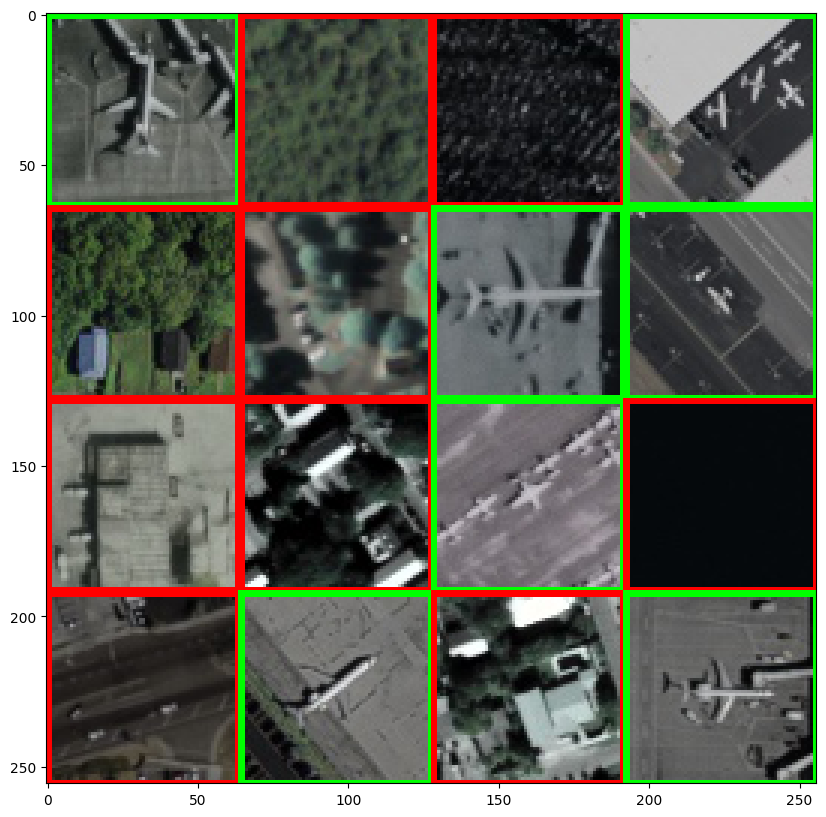

In [9]:
grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(trainval_images[i * grid_size + j])
        label = np.copy(trainval_labels[i * grid_size + j])
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        tile = cv2.rectangle(tile, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

### A bit about train-test

You just downloaded a training and a test set.

- We use the training set for forward/backward
- We use the validation set to tune hyperparameters (optimizers, early stopping)
- We use the test set for final metrics on our tuned model

![](https://github.com/SupaeroDataScience/deep-learning/blob/main/vision/osBuF.png?raw=true)
![](https://raw.githubusercontent.com/SupaeroDataScience/deep-learning/refs/heads/main/vision/pXAfX.png)

For more information as to why we use train/validation and test refer to these articles:

- https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7
- https://www.freecodecamp.org/news/what-to-do-when-your-training-and-testing-data-come-from-different-distributions-d89674c6ecd8/
- https://kevinzakka.github.io/2016/09/26/applying-deep-learning/

We will now create our validation dataset,

Since we know the dataset is balanced, we can evenly sample from the dataset without taking too many risks

We will do a 80/20 sampling

In [10]:
idxs = np.random.permutation(np.arange(trainval_images.shape[0]))

train_idxs, val_idxs = idxs[: int(0.8 * len(idxs))], idxs[int(0.8 * len(idxs)) :]

train_images = trainval_images[train_idxs]
train_labels = trainval_labels[train_idxs]
val_images = trainval_images[val_idxs]
val_labels = trainval_labels[val_idxs]

In [11]:
train_images.shape

(2150, 64, 64, 3)

What is the mean of our data ?
Whats is the standard deviation ?

In [12]:
# Compute the dataset statistics in [0.,1.], we're going to use it to normalize our data

mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
std = np.std(train_images, axis=(0, 1, 2)) / 255.0

mean, std

(array([0.32891145, 0.34135542, 0.32177852]),
 array([0.16913906, 0.16595858, 0.16323007]))

## Preparing our training

Remember that training a deep learning model requires:

- Defining a model to train
- Defining a loss function (cost function) to compute gradients with
- Defining an optimizer to update parameters
- Putting the model on the accelerator device that trains very fast (GPU, TPU)... You'll learn about GPUs later :)

![](https://pbs.twimg.com/media/E_1d06cVIAcYheX?format=jpg)

The training loop is "quite basic" : We loop over samples of the dataset (in batches) several times over :

![](https://pbs.twimg.com/media/E_1d06XVcA8Dhzs?format=jpg)


In [13]:
from typing import Callable

import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

### Defining Dataset & Transforms

First, we need to tell pytorch how to load our data.

Have a look at : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

We write our own `torch.data.Dataset` class

In [14]:
class NpArrayDataset(Dataset):
    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        image_transforms: Callable = None,
        label_transforms: Callable = None,
    ):
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index: int):
        x = self.images[index]
        y = self.labels[index]

        if self.image_transforms is not None:
            x = self.image_transforms(x)
        else:
            x = torch.tensor(x)

        if self.label_transforms is not None:
            y = self.label_transforms(y)
        else:
            y = torch.tensor(y)

        return x, y

Then we need to process our data (images) into "tensors" that torch can process, we define "transforms"

In [15]:
# transform to convert np array in range [0,255] to torch.Tensor [0.,1.]
# then normalize by doing x = (x - mean) / std
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

# here we don't have anything to do
target_transforms = None

Now we put everything together into something to load our data

In [16]:
# load the training data
train_set = NpArrayDataset(
    images=train_images,
    labels=train_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

print(len(train_set))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# load the validation data
validation_set = NpArrayDataset(
    images=val_images,
    labels=val_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

print(len(validation_set))

val_loader = DataLoader(validation_set, batch_size=64, shuffle=True)

2150
538


### Check that your dataset outputs correct data

Always to this as a sanity check to catch bugs in your data processing pipeline

Write the inverse transformation by hand to ensure it's ok

![andrej](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/andrej_tweet_1.png)

Inverse transform is OK ?
Label 1


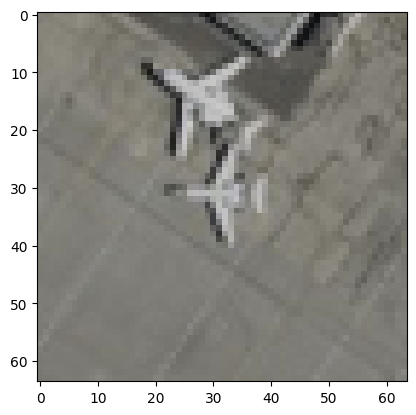

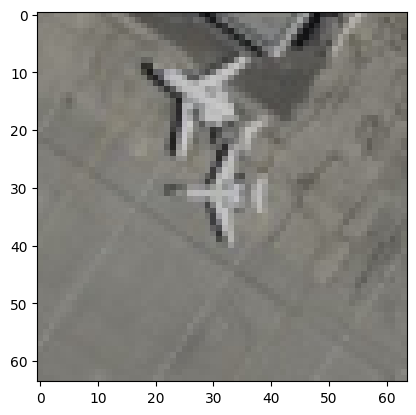

In [18]:
k = np.random.randint(len(train_set))
x, y = train_set[k]

# From torch
# Inverse transform
x = x.numpy()
x = x.transpose((1, 2, 0))
x = x * std + mean
x = x.clip(0.0, 1.0)
x = (x * 255.0).astype(np.uint8)

print("Inverse transform is OK ?")
print("Label {}".format(y))
plt.imshow(x)
plt.show()

plt.imshow(train_set.images[k])
plt.show()

## Model

### On which device will we train ?

We will check if we have a GPU and set the "device" of pytorch on it so that it trains on GPU

In [19]:
# Apple Silicon Support
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
# NVIDIA GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
# Fallback to CPU
else:
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda:0


### Defining a model and computing the parameters

Now we have to define a CNN to train. It's usually called a "network", and we define its "architecture".

Defining a good architecture is a huge field of research (a pandora's box) that takes a lot of time, but we can define "sane architectures" easily:

Basically, CNN architectures are a stacks of :
- Convolution layers + non linearities
- Pooling layer
- A final "activation" layer at the end (for classification) that allows us to output probabilities

![](https://cs231n.github.io/assets/cnn/convnet.jpeg)

Let's define a model together:

```python
model = nn.Sequential(
    # A block of 2 convolutions + non linearities & a pooling layers
    # IN SHAPE (3,64,64)
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
    # OUT SHAPE (16,62,62)
    nn.ReLU(),
    # IN SHAPE (16,62,62)
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
    # OUT SHAPE (16,60,60)
    nn.ReLU(),
    nn.MaxPool2d(2),
    # OUT SHAPE (16,30,30)
    # Another stack of these
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    # OUT SHAPE (?,?,?)
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # OUT SHAPE (?,?,?)
    # Another stack of these
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    # OUT SHAPE (?,?,?)
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
    # OUT SHAPE (?,?,?)
    nn.ReLU(),
    nn.MaxPool2d(2),
    # OUT SHAPE (?,?,?)
    # A final classifier
    nn.Flatten(),
    nn.Linear(in_features=4 * 4 * 64, out_features=256), # do you understand why 4 * 4 * 64 ?
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=256, out_features=64),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=64, out_features=1),
    nn.Sigmoid(),
)
```

**Questions**

Knowing that the input image size is (3,64,64), go through the model step by step,

Can you fill the blanks for the shapes ?

Do you understand why ?

In [24]:
# Let's test this !

some_model = nn.Sequential(
    # IN SHAPE (3,64,64)
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
    # OUT SHAPE (16,62,62)
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
    # OUT SHAPE (16,60,60)
    nn.ReLU(),
    nn.MaxPool2d(2),
    # OUT SHAPE (16,30,30)
    # Another stack of these
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    # OUT SHAPE (32,28,28)
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
    # OUT SHAPE (32,26,26)
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
    # OUT SHAPE (32,24,24)
    nn.ReLU(),
    nn.MaxPool2d(2),
    # OUT SHAPE (32,12,12)
    # Another stack of these
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    # OUT SHAPE (64,10,10)
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
    # OUT SHAPE (64,8,8)
    nn.ReLU(),
    nn.MaxPool2d(2),
    # OUT SHAPE (64,4,4)
    # A final classifier
    nn.Flatten(),
    nn.Linear(in_features=4 * 4 * 64, out_features=256),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=256, out_features=64),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=64, out_features=1),
    nn.Sigmoid(),
)

# We define an input of dimensions batch_size, channels, height, width
x = torch.rand((16, 3, 64, 64))

print(x.shape)

y = some_model(x)

print(y.shape)

# Let's visualize each shape using our summarize helper
print(
    torchinfo.summary(
        some_model,
        input_data=x,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
    )
)

# let's delete the model now, we won't need it
#del some_model

torch.Size([16, 3, 64, 64])
torch.Size([16, 1])
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [16, 3, 64, 64]           [16, 1]                   --
├─Conv2d: 1-1                            [16, 3, 64, 64]           [16, 16, 62, 62]          448
├─ReLU: 1-2                              [16, 16, 62, 62]          [16, 16, 62, 62]          --
├─Conv2d: 1-3                            [16, 16, 62, 62]          [16, 16, 60, 60]          2,320
├─ReLU: 1-4                              [16, 16, 60, 60]          [16, 16, 60, 60]          --
├─MaxPool2d: 1-5                         [16, 16, 60, 60]          [16, 16, 30, 30]          --
├─Conv2d: 1-6                            [16, 16, 30, 30]          [16, 32, 28, 28]          4,640
├─ReLU: 1-7                              [16, 32, 28, 28]          [16, 32, 28, 28]          --
├─Conv2d: 1-8                            [16, 32, 28, 28]          [16, 32, 

**Let's do it yourself !**

About weight init :
- https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
- https://www.pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/

In [26]:
# Let's define another model, except this time there are blanks ... it's up to you to fill them


def _init_weights(model):
    for m in model.modules():
        # Initialize all convs
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")


def model_fn():
    model = nn.Sequential(
        # A first convolution block
        # IN SHAPE (3,64,64)
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
        # OUT SHAPE (16,62,62)
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        # OUT SHAPE (16,60,60)
        nn.ReLU(),
        nn.MaxPool2d(2),
        # OUT SHAPE (16,30,30)
        # Another stack of these
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        # OUT SHAPE (32,28,28)
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        # OUT SHAPE (32,26,26)
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        # OUT SHAPE (32,24,24)
        nn.ReLU(),
        nn.MaxPool2d(2),
        # OUT SHAPE (32,12,12)
        # A final classifier
        nn.Flatten(),
        nn.Linear(in_features= 12 * 12 * 32, out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=64, out_features=1),
        nn.Sigmoid(),
    )

    return model

In [27]:
model = model_fn()

print(model)

x = torch.rand(
    (16, 3, 64, 64)
)  # We define an input of dimensions batch_size, channels, height, width

print(x.shape)

y = model(x)

print(y.shape)

print(
    torchinfo.summary(
        some_model,
        input_data=x,
        col_names=[
            "input_size",
            "output_size",
            "num_params",
        ],
    )
)

# THIS CELL SHOULD NOT GIVE AN ERROR !

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4608, out_features=64, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=64, out_features=1, bias=True)
  (17): Sigmoid()
)
torch.Size([16, 3, 64, 64])
torch.Size([16, 1])
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [16, 3, 64, 64]           [16, 1]            

Hint: The answer (and there can only be one) is :

<details>
    <summary>Solution</summary>
    
```python
def _init_weights(model):
    # about weight initialization
    # https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
    # https://www.pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
    for m in model.modules():
        # Initialize all convs
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")


def model_fn():
    model = nn.Sequential(
        # A first convolution block
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # Another stack of these
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # A final classifier
        nn.Flatten(),
        nn.Linear(in_features=12 * 12 * 32, out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=64, out_features=1),
        nn.Sigmoid(),
    )

    _init_weights(model)

    return model


model = model_fn()

print(model)

x = torch.rand((16, 3, 64, 64))  # We define an input of dimensions batch_size, channels, height, width

print(x.shape)

y = model(x)

print(y.shape)

print(summarize(model,example_input_array=x))
```

And outputs this

```
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4608, out_features=64, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=64, out_features=1, bias=True)
  (17): Sigmoid()
)
torch.Size([16, 3, 64, 64])
torch.Size([16, 1])
   | Name | Type      | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0  | 0    | Conv2d    | 448    | [16, 3, 64, 64]  | [16, 16, 62, 62]
1  | 1    | ReLU      | 0      | [16, 16, 62, 62] | [16, 16, 62, 62]
2  | 2    | Conv2d    | 2.3 K  | [16, 16, 62, 62] | [16, 16, 60, 60]
3  | 3    | ReLU      | 0      | [16, 16, 60, 60] | [16, 16, 60, 60]
4  | 4    | MaxPool2d | 0      | [16, 16, 60, 60] | [16, 16, 30, 30]
5  | 5    | Conv2d    | 4.6 K  | [16, 16, 30, 30] | [16, 32, 28, 28]
6  | 6    | ReLU      | 0      | [16, 32, 28, 28] | [16, 32, 28, 28]
7  | 7    | Conv2d    | 9.2 K  | [16, 32, 28, 28] | [16, 32, 26, 26]
8  | 8    | ReLU      | 0      | [16, 32, 26, 26] | [16, 32, 26, 26]
9  | 9    | Conv2d    | 9.2 K  | [16, 32, 26, 26] | [16, 32, 24, 24]
10 | 10   | ReLU      | 0      | [16, 32, 24, 24] | [16, 32, 24, 24]
11 | 11   | MaxPool2d | 0      | [16, 32, 24, 24] | [16, 32, 12, 12]
12 | 12   | Flatten   | 0      | [16, 32, 12, 12] | [16, 4608]      
13 | 13   | Linear    | 294 K  | [16, 4608]       | [16, 64]        
14 | 14   | ReLU      | 0      | [16, 64]         | [16, 64]        
15 | 15   | Dropout   | 0      | [16, 64]         | [16, 64]        
16 | 16   | Linear    | 65     | [16, 64]         | [16, 1]         
17 | 17   | Sigmoid   | 0      | [16, 1]          | [16, 1]         
--------------------------------------------------------------------------
320 K     Trainable params
0         Non-trainable params
320 K     Total params
1.284     Total estimated model params size (MB)
```

</details>


You should be able to understand this

In [28]:
# moving model to gpu if available
model = model.to(DEVICE)

### Defining our loss and optimizer

Check the definition of the binary cross entropy:

https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss

In [29]:
criterion = nn.BCELoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

## Training with pytorch

We will actually train the model, and plot training & validation metrics during training

Be careful, if you train several times the same model it will continue optimizing its parameters

Its advised to define a new model if you are executing the training loop several times

### Defining the Training loop

In [30]:
def train_one_epoch(model, train_loader):
    epoch_loss = []

    for i, batch in enumerate(train_loader):
        # get one batch
        x, y_true = batch
        x = x.to(DEVICE)
        y_true = y_true.to(DEVICE)

        # format the y_true so that it is compatible with the loss
        y_true = y_true.view((-1, 1)).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        y_pred = model(x)

        # compute loss
        loss = criterion(y_pred, y_true)

        # backward
        loss.backward()

        # update parameters
        optimizer.step()

        # save statistics
        epoch_loss.append(loss.item())

        if i % 10 == 0:
            print(f"Batch {i}, curr loss = {loss.item():.03f}")

    return np.asarray(epoch_loss).mean()


def valid_one_epoch(model, valid_loader):
    epoch_loss = []

    for i, batch in enumerate(valid_loader):
        with torch.no_grad():
            # get one batch
            x, y_true = batch
            x = x.to(DEVICE)
            y_true = y_true.to(DEVICE)

            # format the y_true so that it is compatible with the loss
            y_true = y_true.view((-1, 1)).float()

            # forward
            y_pred = model(x)

            # compute loss
            loss = criterion(y_pred, y_true)

            # save statistics
            epoch_loss.append(loss.item())

    return np.asarray(epoch_loss).mean()

### Putting everything together to run a training

**Hyperparameters**

We also define what we call hyperparameters, the "meta-parameters" of the training that you can modify to affect your training

In [31]:
EPOCHS = 10  # Set number of epochs, example 100
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

Here we copy paste previous code into a function (so that you reset your training everytime) so that you are sure you have setup everything correctly


In [32]:
def setup_training():
    model = model_fn()

    # moving model to gpu if available
    model = model.to(DEVICE)

    print(model)

    # We define an input of dimensions batch_size, channels, height, width
    x = torch.rand((16, 3, 64, 64))
    x = x.to(DEVICE)

    print(x.shape)

    y = model(x)

    print(y.shape)

    print(torchinfo.summary(model, input_data=x))

    criterion = nn.BCELoss(reduction="mean")
    optimizer = optim.SGD(
        model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=1e-4
    )

    return model, criterion, optimizer

Why do we wrap it into a function ? Try executing your notebook in the wrong order and see what happens !

You can see that if you redefine a model, then the optimizer is called on the wrong parameters !

Note that we defined some hyperparameters beyond the function, be careful of what we call "the scope". You could also pass them as parameters of your function

Let's go !

In [33]:
# Init the training
model, criterion, optimizer = setup_training()

# Send model to GPU
model = model.to(DEVICE)

train_losses = []
valid_losses = []

# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, train_loader)
    model.eval()
    valid_epoch_loss = valid_one_epoch(model, val_loader)

    print(f"EPOCH={epoch}, TRAIN={train_epoch_loss:.05f}, VAL={valid_epoch_loss:.05f}")

    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4608, out_features=64, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=64, out_features=1, bias=True)
  (17): Sigmoid()
)
torch.Size([16, 3, 64, 64])
torch.Size([16, 1])
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 1]                   --
├─Conv2d: 1-1                            [

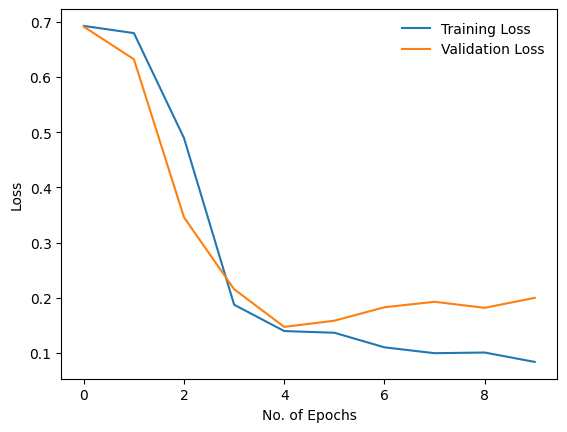

In [34]:
# Plot training / validation loss
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

### Training analysis

How would you analyze your training ?

Is it underfitting ?

Is it overfitting ?

### Model saving

There are several ways to save your model :
https://pytorch.org/tutorials/beginner/saving_loading_models.html

- torch.save: Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.

- torch.load: Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).

- torch.nn.Module.load_state_dict: Loads a model’s parameter dictionary using a deserialized state_dict. For more information on state_dict, see What is a state_dict?.

- scripting / tracing the model: https://pytorch.org/docs/stable/jit.html

The first 2 options require you to import the model definition as it uses pickle
The third option requires you to redefine an empty model with the same architecture and load the weights, because we are only saving the "state" (e.g. parameters, weights, biases)
The fourth option allow to make a "self-contained" model that can be used later, but comes with caveats

### State dict saving

This is the recommended method because it allows to reuse the model with any code

In [35]:
# State dict saving
with open("model.pt", "wb") as f:
    torch.save(model.state_dict(), f)

# See below for how to reload the model

To reload such a model, you have to instantiate an empty model with the same architecture then load the state dict (the weights)
```python
# Instantiate a new empty model
model = model_fn()

print(model)

# Load state
checkpoint_path = "model.pt"
model.load_state_dict(torch.load(checkpoint_path))

print("Model Loaded")
```

This is very nice because you get a model that you can finetune, retrain, modify. However, this means that you have to "port" the model definition code to production.

### Model scripting

But for production, in order to avoid shipping the model definition code, we like to have an "self-contained" binary that we can deliver to the production team (you will see such a case during our next class together for cloud computing)

Here we try to "script" the model, meaning that we compile the graph to a static version of itself

https://pytorch.org/docs/stable/jit.html

In [36]:
import torch.jit

# Put the model in eval mode
model = model.cpu().eval()

# Script the model
scripted_model = torch.jit.script(model)

# Save
scripted_model.save("scripted_model.pt")

print(scripted_model)

# Scripted model reloading (demo)
scripted_model = torch.jit.load("scripted_model.pt", map_location=DEVICE)

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Conv2d)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=MaxPool2d)
  (5): RecursiveScriptModule(original_name=Conv2d)
  (6): RecursiveScriptModule(original_name=ReLU)
  (7): RecursiveScriptModule(original_name=Conv2d)
  (8): RecursiveScriptModule(original_name=ReLU)
  (9): RecursiveScriptModule(original_name=Conv2d)
  (10): RecursiveScriptModule(original_name=ReLU)
  (11): RecursiveScriptModule(original_name=MaxPool2d)
  (12): RecursiveScriptModule(original_name=Flatten)
  (13): RecursiveScriptModule(original_name=Linear)
  (14): RecursiveScriptModule(original_name=ReLU)
  (15): RecursiveScriptModule(original_name=Dropout)
  (16): RecursiveScriptModule(original_name=Linear)
  (17): RecursiveScriptModule(original_name=Sigmoid)
)


### Download the scripted model

We are going to download the scripted model to be able to re-use it elsewhere (in another notebook for example), without having to rewrite the model definition function

Uncomment this on google colab to download the model

In [37]:
from google.colab import files

files.download('scripted_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We have finished what we need to do with the model, let's delete it !

In [38]:
del model

## Testing our models and computing metrics

Now that we have a trained network, it is important to measure how well it performs. We do not do that during training because theoretically we try to test on a context closer to how the final model will be used, meaning this can be another pipeline and is usually outside the training engine.

You can refer to your ML course or on resources on the web to see how we can measure it.

### Loading saved model

State dict method

In [39]:
# Instantiate a new empty model
model = model_fn()

print(model)

# Load state
checkpoint_path = "model.pt"
model.load_state_dict(
    torch.load(
        checkpoint_path, weights_only=True, map_location=lambda storage, loc: storage
    )
)

print("Model Loaded")

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4608, out_features=64, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=64, out_features=1, bias=True)
  (17): Sigmoid()
)
Model Loaded


### Inferencing on the test dataset

Now we will run predictions on the test dataset using the newly loaded model

In [40]:
test_ds = NpArrayDataset(
    images=test_images,
    labels=test_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

In [41]:
import tqdm

In [42]:
y_true = []
y_pred = []

# Send model to correct device
model.to(DEVICE)

# Put model in evaluatio mode (very important)
model.eval()

# Disable all gradients things
with torch.no_grad():
    for x, y_t in tqdm.tqdm(test_ds, "predicting"):
        x = x.reshape((-1,) + x.shape)
        x = x.to(DEVICE)
        y = model.forward(x)
        y = y.to("cpu").numpy()

        y_t = int(y_t.to("cpu").numpy())

        y_pred.append(y)
        y_true.append(y_t)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.asarray(y_true)

predicting: 100%|██████████| 896/896 [00:02<00:00, 426.77it/s]


In [43]:
print(y_pred.shape)

print(y_pred[4])

(896, 1)
[0.9999989]


In [44]:
y_pred_classes = y_pred[:, 0] > 0.5

### Confusion matrix
Here, we are first computing the [confusion matrix]():

Confusion matrix


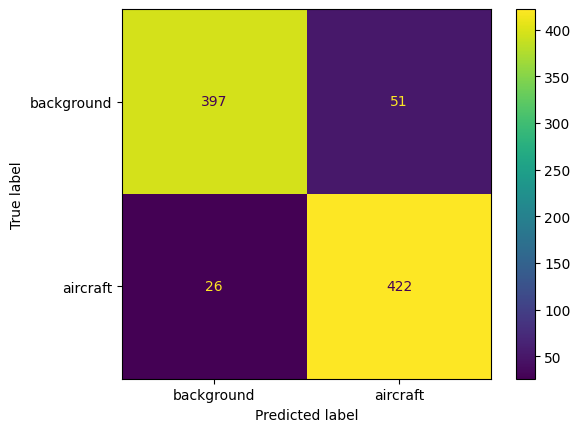

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["background", "aircraft"]
)

disp.plot()
plt.show()

### ROC curve

The next metric we are computing is the [Receiver Operating Characteristic](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The method was originally developed for operators of military radar receivers starting in 1941, which led to its name.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/512px-Roc_curve.svg.png)

![](http://algolytics.com/wp-content/uploads/2018/05/roc1_en.png)

It is used to choose a threshold on the output probability in case you are interesting in controling the false positive rate.

**In our case : which is the positive class ? which is the negative class ?**

In [46]:
# Compute ROC curve and Area Under Curver

from sklearn.metrics import auc, roc_curve

# We round predictions for better readability
y_pred_probas = np.round(y_pred[:, 0], 2)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probas)
roc_auc = auc(fpr, tpr)

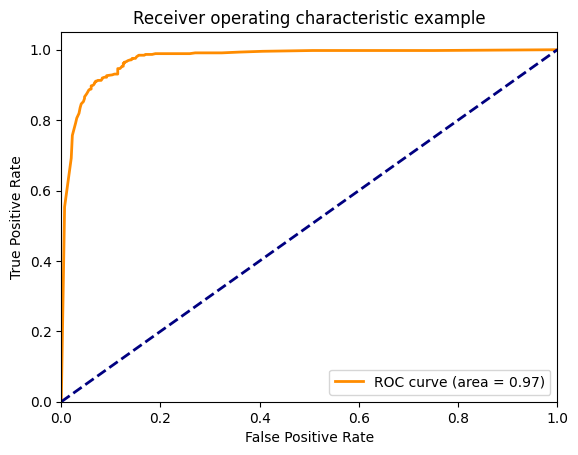

In [47]:
plt.figure()
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### Using the ROC curve to select an optimal threshold

The ROC curve can be used to select the best decision threshold for classifying an aircraft as positive.

Plot the ROC curve with thresholds assigned to points in the curve (you can round the predictions for a simpler curve)

<Figure size 640x480 with 0 Axes>

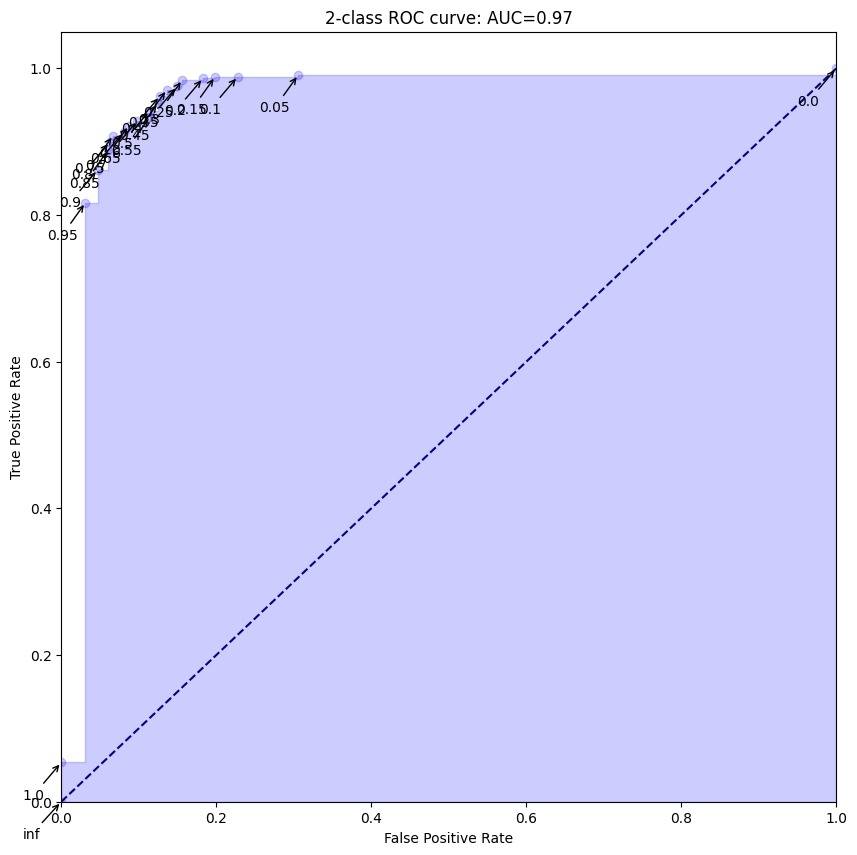

In [48]:
# We round predictions every 0.05 for readability
y_pred_probas = (y_pred[:, 0] / 0.05).astype(np.int64) * 0.05

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probas)
roc_auc = auc(fpr, tpr)

plt.clf()
fig = plt.figure(figsize=(10, 10))
plt.step(fpr, tpr, "bo", alpha=0.2, where="post")
plt.fill_between(fpr, tpr, alpha=0.2, color="b", step="post")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("2-class ROC curve: AUC={:0.2f}".format(roc_auc))
plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")

for tp, fp, t in zip(tpr, fpr, thresholds):
    plt.annotate(
        np.round(t, 2),
        xy=(fp, tp),
        xytext=(fp - 0.05, tp - 0.05),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
    )
plt.savefig("roc_curve_thresholds.png")
plt.show()

Now, choose a threshold on the curve where you miss less than 10% of the aircrafts

Confusion matrix


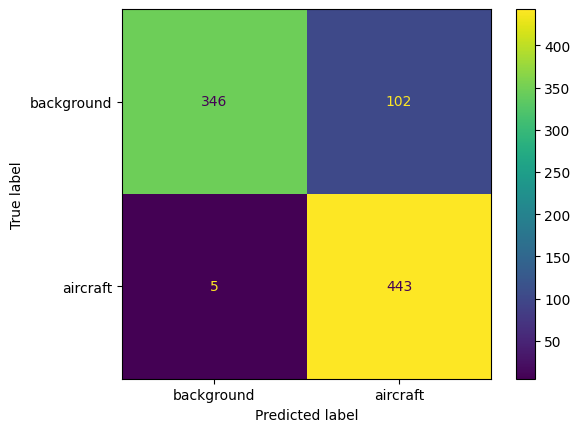

In [49]:
selected_threshold = 0.10

print("Confusion matrix")

y_pred_classes = y_pred_probas >= selected_threshold

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["background", "aircraft"]
)

disp.plot()
plt.show()

# How did the confusion matrix evolve ? Does it match your intuition ?

**Food for thought** :
- How would you generalize this method if you had 10 (exclusive) classes ? Example with MNIST or [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) ?
- Would you select one general threshold or one threshold per class ? Or maybe get the max proba then threshold it differently with each class ?

### Misclassified examples

It is always interesting to check mis classified examples.

It usually provides tips on how to improve your model.

107
[  7  17  20  22  23  29  38  42  54  59  61  63  67  91  92  94 111 113
 115 123 133 149 167 172 174 189 194 197 211 223 224 243 253 258 278 281
 283 284 285 287 301 302 305 313 314 321 327 330 333 340 345 352 375 390
 391 392 401 405 423 427 482 492 506 515 519 526 537 546 550 555 579 586
 589 596 603 607 628 633 650 658 666 672 682 687 694 696 735 754 762 777
 778 784 793 796 797 820 825 841 850 855 869 870 876 880 882 885 889]


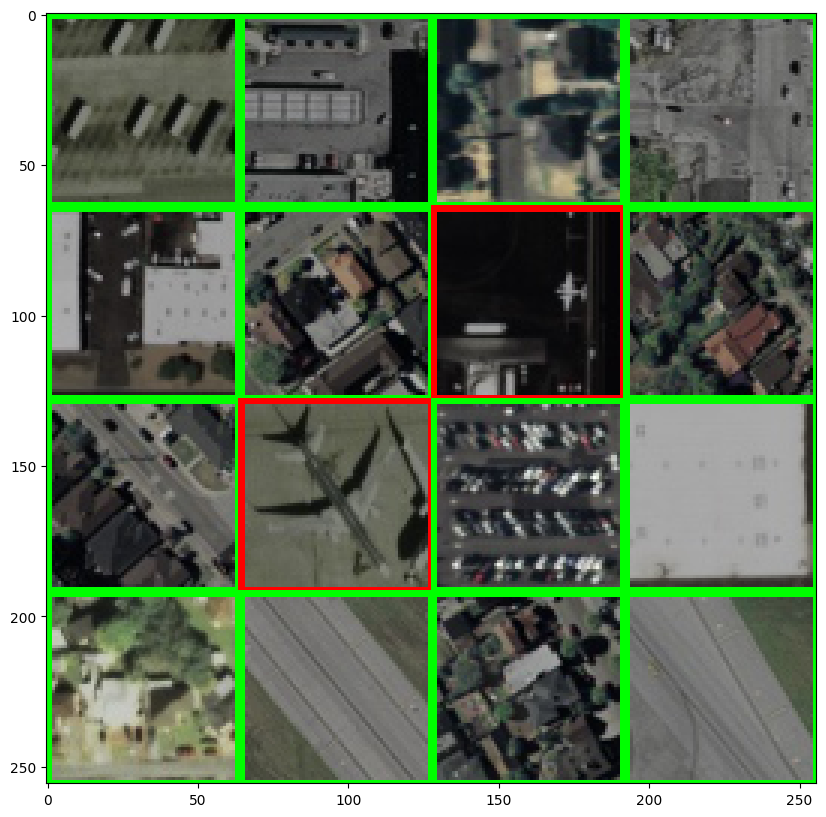

In [50]:
misclassified_idxs = np.where(y_pred_classes != y_true)[0]

print(len(misclassified_idxs))

print(misclassified_idxs)

misclassified_images = test_images[misclassified_idxs]
misclassified_true_labels = test_labels[misclassified_idxs]
misclassified_pred_labels = y_pred_classes[misclassified_idxs]

grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        img = np.copy(misclassified_images[i * grid_size + j])
        pred = np.copy(misclassified_pred_labels[i * grid_size + j])
        color = (0, 255, 0) if pred == 1 else (255, 0, 0)
        tile = cv2.rectangle(img, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

## Improving our training / validation loop

We will add more advanced features to our training loop for better models

Copy the train / valid loop and update it accordingly

### Computing accuracy during training / validation

Update the `valid_one_epoch` to compute accuracy during during the validation loop, and plot its evolution during training

Use the ROC curve computation where we compute the pred / true classes as inspiration

Here's an example (that needs to be modified)
```python

correct_pred = 0
total_pred = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = net(images)
        predictions = torch.round(outputs)[:,0]
        # collect the correct predictions
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1
            total_pred += 1
            
    # print accuracy
    accuracy = 100 * (total_pred / total_pred)
    print("Accuracy is: {:.1f} %".format(accuracy))

```                                             

### Early stopping

You've seen that it is possible to overfit it you're not careful,

**Go back to your previous class and adapt the training loop to add early stopping**

### Data Augmentation


One technique for training CNNs on images is to put your training data through data augmentation to generate similar-but-different examples to make your network more robust.

You can generate "augmented images" on the fly or use composition to generate data

- We are going to wrap our numpy arrays with `torch.utils.data.Dataset` class

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

- Here is how we use torch Compose to augment data

https://pytorch.org/docs/stable/torchvision/transforms.html

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms

Note: This step requires a bit of tinkering from numpy arrays to torch datasets, it's fine if you skip it. For the next notebook it may prove a useful way of gaining performance

**Remember : We apply data augmentation only during training**


In [ ]:
import torch.functional as F
import torch.utils
import torchvision.transforms

In [ ]:
# Example (very simple) data augmentation to get your started, you can add more transforms to this list

train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std),
    ]
)

In [ ]:
# Example
trainset_augmented = NpArrayDataset(
    images=train_images,
    labels=train_labels,
    image_transforms=train_transform,
    label_transforms=None,
)

In [ ]:
# Get image from dataset. Note: it has been converted as a torch tensor in CHW format in float32 normalized !
img, label = trainset_augmented[0]
img = img.numpy().transpose((1, 2, 0)) * std + mean
img = img.clip(0.0, 1.0)
img = (img * 255.0).astype(np.uint8)
plt.imshow(img)
plt.show()

# Compare effects of data augmentation
img_orig = trainset_augmented.images[0]
plt.imshow(img_orig)
plt.show()

In [ ]:
# do another training and plot our metrics again. Did we change something ?

### Best checkpoint

You've seen how to save model checkpoint. However we saved the model at the end of training. What if there is an issue (like overfitting ? or our computer crashes !!!) ?

How to keep a good copy of our model at any point ?

The idea is that during the training, we always save the checkpoint with the lowest valid loss, then reload it at the end of training

**Modify the train loop to keep the best model state dict at any point, then reload it at the end of training**


## Food for thoughts: Tooling

To conclude this notebook, reflect on the following,

You have launched different experiences and obtained different results,

Did you feel the notebook you used was sufficient ? Which tools would you like to have in order to properly run your experiments ? (Quick google search or ask someone) Do they already exist ?

### **Presentation : High level frameworks**

<img src="https://raw.githubusercontent.com/pytorch/ignite/master/assets/logo/ignite_logo_mixed.svg" alt="ignite" style="width: 400px;"/>

Pytorch ignite is what we call a "high-level library" over pytorch, its objectives is to abstract away most of the boilerplate code for training deep neural network.

Usually, they make the development process easier by enabling you to focus on what's important instead of writing distributed and optimized training loops and plugging metrics / callbacks. Because we all forgot to call `.backward()` or `.zero_grad()` at least once.

Here an overview of the high-level libraries available for pytorch,

https://neptune.ai/blog/model-training-libraries-pytorch-ecosystem?utm_source=twitter&utm_medium=tweet&utm_campaign=blog-model-training-libraries-pytorch-ecosystem

Of these, we would like to highlight three of them:

- pytorch-ignite, officially sanctioned by the pytorch team (its repo lives at https://pytorch.org/ignite/), which is developped by [someone from Toulouse](https://twitter.com/vfdev_5) - yes there is a member of the pytorch team living in Toulouse, we are not THAT behind in ML/DL :wishful-thinking:

- pytorch-lightning (https://www.pytorchlightning.ai/) which has recently seen its 1.0 milestone and has been developped to a company. It is more "research oriented" that pytorch-ignite, and with a lower abstraction level, but seems to enable more use case.

- catalyst (https://github.com/catalyst-team/catalyst)

- skorch (https://github.com/skorch-dev/skorch). This class was previously written in skorch. Skorch mimics the scikit-learn API and allows bridging the two libraries together. It's a bit less powerful but you write much less code than the two libraries above, and if you are very familiar with scikit-learn, it could be very useful for fast prototyping


**Take a look at the [previous class](https://nbviewer.jupyter.org/github/SupaeroDataScience/deep-learning/blob/main/deep/PyTorch%20Ignite.ipynb), the [official examples](https://nbviewer.jupyter.org/github/pytorch/ignite/tree/master/examples/notebooks/) or the [documentation](https://pytorch.org/ignite/) if want to learn about Ignite**

## **Optional** exercises to run at home

If you're done with this, you can explore a little bit more : Now that we have a nice training loop we can do hyperparameter tuning !

As you can see, there are a lot of parameters we can choose:

- the optimizer
- the learning rate
- the model architecture

etc... !


- Try to play with network hyperparameters. The dataset is small and allow fast iterations so use it to have an idea on hyperparameter sensitivity.
    number of convolutions, other network structures, learning rates, optimizers,...

- Example: Compare again SGD and ADAM

- Try to use the ROC curve to select a threshold to filter only negative examples without losing any positive examples

When you are done with the warmup, go to the next notebook. But remember that next datasets will be larger and you will not have the time (trainings will take longer ) to experiment on hyperparameters.

**You can try more things**

### Optimizer Changes
Change the optimizer from SGD to optim.Adam. Is it better ?

In [ ]:
# HERE

### Batch Normalization

One of the most used "layer" beyond conv / pool / relu is "batch normalization",

http://d2l.ai/chapter_convolutional-modern/batch-norm.html

Try adding it to your network and see what happens !

<details>

```python
def model_fn():
    model = nn.Sequential(
        # A first convolution block
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # Another stack of these
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # A final classifier
        nn.Flatten(),
        nn.Linear(in_features=12 * 12 * 32, out_features=64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=64, out_features=1),
        nn.Sigmoid(),
    )

    return model
```
    
</details>

### Trying other models

You have seen a class on different model structure,
https://supaerodatascience.github.io/deep-learning/slides/2_architectures.html#/

Now is the time to try and implement them.

For example, try to write a VGG-11 with fewer filters by yourself... or a very small resnet using [this](https://github.com/a-martyn/resnet/blob/master/resnet.py) as inspiration

You can also use models from [torchvision](https://pytorch.org/docs/stable/torchvision/models.html#classification) in your loop, or as inspiration


**Modify the model structure and launch another training... Is it better ?**

In [ ]:
# HERE

### LR Scheduling

Sometimes it's best to reduce the learning rate if you stop improving, or to reduce learning rate at the end of training

Tutorial : https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/#top-basic-learning-rate-schedules

- **Modify the train loop to change the learning rate when the validation loss is stagnating**

- **Modify the train loop to change the learning rate when the validation loss is stagnating**

In [ ]:
# ...

### How to train neural networks ?

You must have noticed that training neural networks depends on a lot of different things : hyperparameters, architectures, data, ...

It's an experimental science that requires some tuning... and such tuning can yield very decreasing improvements over time. It's a kind of special hell / pandora's box.

Here are some very interesting links on getting started the right way when training neural networks :

http://cs231n.stanford.edu/slides/2023/lecture_7.pdf

https://cs231n.stanford.edu/slides/2024/lecture_6_part_2.pdf

https://karpathy.github.io/2019/04/25/recipe/